In [326]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sc
import matplotlib.pyplot as plt
import yaml


from models.model2_linear import Dynamic_Bicycle_Linear
from models.utils import fit_circle
import time

In [365]:
np.random.seed(100)
class Param_Inferencer:
    def __init__(self) -> None:
        # List of parameters to infer
        self.list_of_param = ['T_peak']
        # Number of paramters to infer
        self.param_to_infer = len(self.list_of_param)
        # Sample vector
        self.thetas = np.random.rand(self.param_to_infer + 1).reshape(1,-1) # First one is random + likelihood
        # Burnin
        self.burnin = None

        # Current model and model parameters
        self.model = None
        self.dt = 0.05
        self.open_loop_tf = 20
        self.T_slope = 0.4
        self.velocity = 5
        # T peak is not specified since we infer tit

        # Load the CSV file using numpy.genfromtxt()
        data = np.genfromtxt('./Data/Data_Bicycle_linear/radiuses.csv', delimiter=',', names=True, dtype=None)
        self.y_likelihood = float(data['R'])
        print(self.y_likelihood)


    def get_circle_radius(self, tetha):
        '''
            Gets the radius of  the circle from the open loop simulation
            @param name_of-param
        '''
        # Generate the right tyre1000.yaml file (Let's call it 1000 by convention)
        self.generate_new_model(tetha[:self.param_to_infer])
        
        # Generate the new data
        t0 = 0
        N = self.model.open_loop_tf/self.model.dt
        steering = 0.2
        torque = 40
        inputs = [steering, torque, torque, torque, torque]
        t,x_vect = self.model.do_open_loop_sim_cst_inputs(t0, inputs)
        
        # Fetch the radius from the data
        x = x_vect[int(N/2):,0]
        y = x_vect[int(N/2):,1]
        radius = fit_circle(x, y) 
        
        return radius
    
    def generate_new_model(self, T_peak):
        self.model = Dynamic_Bicycle_Linear(self.velocity, self.dt, self.open_loop_tf,float(T_peak), self.T_slope)

    #----------------- Functions from here take care of the inference -----------------#

    def proposal(self, prec_theta, search_width = 0.5):
        # this function generates the proposal for the new theta
        # we assume that the distribution of the random variables 
        # is normal for the first two and gamma for the third.
        # conditional on the previous value of the accepted parameters (prec_theta)
        start_time = time.time()
        out_theta = np.zeros(self.param_to_infer+1)
        out_theta[:self.param_to_infer] = sc.multivariate_normal(mean=prec_theta[:self.param_to_infer],cov=np.eye(self.param_to_infer)*search_width**2).rvs(1)
        #the last component is the noise
        out_theta[self.param_to_infer] = sc.gamma(a=prec_theta[self.param_to_infer]*search_width*500, scale=1/(500*search_width)).rvs()
        end_time = time.time()
        return out_theta
    
    def log_likelihood(self, tetha):
        proposed_radius = self.get_circle_radius(tetha)
        #mean = np.full(self.y_likelihood.shape[0], proposed_radius).reshape(-1,1)
        log_likelihood_vect = sc.norm.logpdf(self.y_likelihood, loc= proposed_radius, scale=tetha[self.param_to_infer]) # Loc will be simulation(theta(:param_to_infer), scale = theta[param_to_infer])
        log_likelihood_out = np.sum(log_likelihood_vect)
        return log_likelihood_out

    def log_prior(self, theta):
        start_time = time.time()
        # evaluate the prior for the parameters on a multivariate gaussian. 
        prior_out = sc.multivariate_normal.logpdf(theta[:self.param_to_infer],mean=np.zeros(self.param_to_infer), cov=np.eye(self.param_to_infer)*100)
        # this needs to be summed to the prior for the sigma, since I assumed independence.
        prior_out += sc.gamma.logpdf(theta[self.param_to_infer], a=1, scale=1)
        end_time = time.time()
        return prior_out


    def log_proposal_x_given_y(self, x,y, search_width = 10):
        walk = 1
        # Parameters
        log_proposal_param = sc.multivariate_normal.logpdf(x[:self.param_to_infer],mean=y[:self.param_to_infer], cov=np.eye(self.param_to_infer)*search_width**2)
        # Standard deviation
        log_proposal_std_dev = sc.gamma.logpdf(x[self.param_to_infer], a=y[self.param_to_infer]*walk*500, scale=1/(500*walk))
        
        log_proposal_x_given_y = log_proposal_param+log_proposal_std_dev
        return log_proposal_x_given_y

    def acceptance_prob(self, log_likelihood_theta, log_likelihood_theta_new, log_prior_theta, log_prior_theta_new, log_proposal_theta_given_theta_new, log_proposal_theta__new_given_theta):
        prop_ratio = log_proposal_theta_given_theta_new-log_proposal_theta__new_given_theta
        likelihood_prior_proposal_ratio = -log_likelihood_theta_new + log_likelihood_theta - \
                                log_prior_theta_new + log_prior_theta - prop_ratio
        return np.exp(likelihood_prior_proposal_ratio)

    def inference(self):
        # Number of samples accepted/rejected
        accepted = 0
        rejected = 0
        # Number of iterations
        iter = 10000
        # Scale facter of the covariance matrix
        width = 0.01

        accepted_thetas = np.random.rand(self.param_to_infer + 1).reshape(1,-1)
        rejected_thetas = np.empty(self.param_to_infer + 1).reshape(1,-1)
        all_thetas = np.concatenate((accepted_thetas, np.zeros((accepted_thetas.shape[0], 1))), axis=1)
        # Loop for the inference
        for i in range(iter):
            
            # 1) Provide a proposal for theta
            theta_new = self.proposal(accepted_thetas[-1,:], search_width=width)

            # 2) Compute log-likelihood of the new theta and the old one

            log_likelihood_theta = self.log_likelihood(accepted_thetas[-1,:])
            
            log_likelihood_theta_new = self.log_likelihood(theta_new)
            
            

            # 3) Compute log-prior of the new theta and the old one
            log_prior_theta = self.log_prior(accepted_thetas[-1,:])
            log_prior_theta_new = self.log_prior(theta_new)
            

            # 4) Compute log-proposal of the new theta and the old one
            log_proposal_theta_given_theta_new = self.log_proposal_x_given_y(accepted_thetas[-1,:], theta_new, search_width =width)
            log_proposal_theta__new_given_theta = self.log_proposal_x_given_y(theta_new, accepted_thetas[-1,:], search_width =width)

            # 5) Compute the acceptance probability
            alpha = self.acceptance_prob(log_likelihood_theta, log_likelihood_theta_new, log_prior_theta, log_prior_theta_new, log_proposal_theta_given_theta_new, log_proposal_theta__new_given_theta)

            #6) Generate a uniform number u from [0,1]
            '''u = sc.uniform().rvs()
            # if u <= alpha, accept the new sample
            if u <= alpha:
                thetas = np.vstack((thetas,theta_new))
                accepted += 1
            else:
                rejected += 1'''
            u = sc.uniform().rvs()
            if alpha <= u:
                accepted_thetas = np.vstack((accepted_thetas,theta_new))
                accepted += 1
                theta_new_all_thetas = np.hstack((theta_new, np.array([1]).reshape(-1,)))
            else:
                rejected_thetas = np.vstack((rejected_thetas,theta_new))
                rejected += 1
                theta_new_all_thetas = np.hstack((theta_new, np.array([0]).reshape(-1,)))
            
            all_thetas = np.vstack((all_thetas,theta_new_all_thetas))

            if i%50 == 0:
                print('Iteration ', i)
    
        
        return accepted_thetas, rejected_thetas, all_thetas

In [366]:
PI = Param_Inferencer()

accepted_thetas, rejected_thetas, all_thetas = PI.inference()

7.438844233517212
Iteration  0
Iteration  0


/var/folders/mw/9cttllqs2yv0dqrlc62m0l8h0000gn/T/ipykernel_23903/4044256189.py:99: RuntimeWarning: overflow encountered in exp
  return np.exp(likelihood_prior_proposal_ratio)


Iteration  50
Iteration  50
Iteration  100
Iteration  100
Iteration  150
Iteration  150
Iteration  200
Iteration  200
Iteration  250
Iteration  250
Iteration  300
Iteration  300
Iteration  350
Iteration  350
Iteration  400
Iteration  400
Iteration  450
Iteration  450
Iteration  500
Iteration  500
Iteration  550
Iteration  550
Iteration  600
Iteration  600
Iteration  650
Iteration  650
Iteration  700
Iteration  700
Iteration  750
Iteration  750
Iteration  800
Iteration  800
Iteration  850
Iteration  850
Iteration  900
Iteration  900
Iteration  950
Iteration  950
Iteration  1000
Iteration  1000
Iteration  1050
Iteration  1050
Iteration  1100
Iteration  1100
Iteration  1150
Iteration  1150
Iteration  1200
Iteration  1200
Iteration  1250
Iteration  1250
Iteration  1300
Iteration  1300
Iteration  1350
Iteration  1350
Iteration  1400
Iteration  1400
Iteration  1450
Iteration  1450
Iteration  1500
Iteration  1500
Iteration  1550
Iteration  1550
Iteration  1600
Iteration  1600
Iteration  1650


In [367]:
def plot_column_histograms(data):
    """
    Plots a histogram for each column of a 2D numpy array.
    """
    num_cols = data.shape[1]  # Get the number of columns in the data
    
    # Plot a histogram for each column
    for i in range(num_cols):
        plt.hist(data[:, i], bins=10)  # Plot the histogram
        
        # Set the plot title and axis labels
        plt.title(f"Histogram of Column {i}")
        plt.xlabel("Value")
        plt.ylabel("Frequency")
        
        plt.show()  # Show the plot

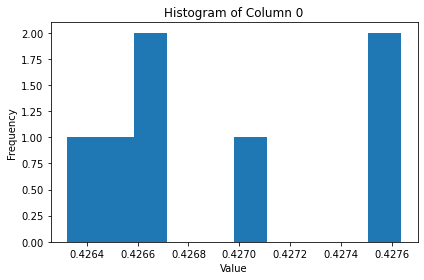

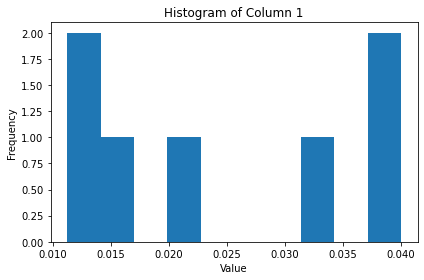

17

In [369]:
burnin = 10
plot_column_histograms(accepted_thetas[burnin:])
accepted_thetas.shape[0]

In [349]:
all_thetas

array([[4.24517591e-01, 8.44776132e-01, 0.00000000e+00],
       [4.34330799e-01, 9.99102048e-01, 0.00000000e+00],
       [4.22622632e-01, 8.83102155e-01, 0.00000000e+00],
       ...,
       [3.80117045e-01, 2.99950972e-05, 0.00000000e+00],
       [3.81522712e-01, 1.43035929e-11, 0.00000000e+00],
       [3.94540397e-01, 7.63446282e-10, 0.00000000e+00]])

In [350]:
thetas[10:]

array([[0.38181818, 0.11039124],
       [0.37421584, 0.10390494],
       [0.34569775, 0.12000005],
       [0.33273809, 0.10539323]])

In [122]:

y = np.array([1,2,3,4,5])
a = np.full(5,5)
b = 5
log_likelihood_vect_a = sc.norm.logpdf(y, loc= a, scale=0.5)
log_likelihood_vect_b = sc.norm.logpdf(y, loc= b, scale=0.5)

In [212]:
param_to_infer = 1

accepted_thetas = np.random.rand(param_to_infer + 1).reshape(1,-1)
print(accepted_thetas.shape)
rejected_thetas = np.empty(param_to_infer + 1).reshape(1,-1)
all_thetas = np.concatenate((accepted_thetas, np.zeros((1, 1))), axis=1)

test =np.array([1,2]).reshape(2,)
third_col = np.array([1]).reshape(-1,)
result = np.hstack((test, third_col))
result



(1, 2)


array([1, 2, 1])

In [183]:
accepted_thetas

array([[0.28589569, 0.85239509]])

In [184]:
all_thetas


array([[0.28589569, 0.85239509, 0.        ]])

In [168]:
accepted_thetas.shape

(1, 2)

In [174]:
array = np.array([[2, 3]])  # Shape: (1, 2)
column_of_ones = np.ones((array.shape[0], 1))
result = np.concatenate((array, column_of_ones), axis=1)

In [207]:
test = np.array([1, 2]).reshape(2,)
third_column = np.array([1]).reshape(1,)
result = np.column_stack((test, third_column))

print(result)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 2 and the array at index 1 has size 1

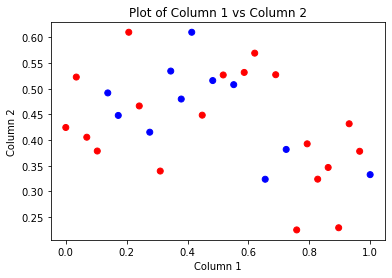

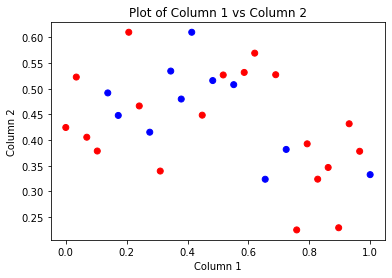

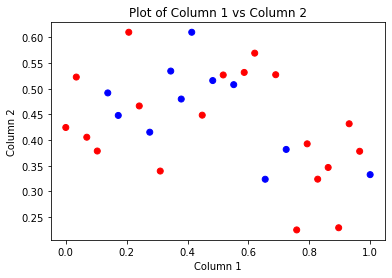

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

data = np.array([[0.42451759, 0.84477613, 0.],
                 [0.52264967, 0.90646317, 0.],
                 [0.40556801, 0.87155962, 0.],
                 [0.37871489, 0.89572147, 0.],
                 [0.49178967, 0.82466402, 1.],
                 [0.44797611, 0.68313331, 1.],
                 [0.60987428, 0.87208974, 0.],
                 [0.46642798, 0.79142294, 0.],
                 [0.4153523,  0.68296332, 1.],
                 [0.33971707, 0.77576442, 0.],
                 [0.53431453, 0.49811519, 1.],
                 [0.47987061, 0.42813698, 1.],
                 [0.60984542, 0.28153585, 1.],
                 [0.44848757, 0.39896992, 0.],
                 [0.51584081, 0.2179391,  1.],
                 [0.52672715, 0.24603079, 0.],
                 [0.50787968, 0.15855377, 1.],
                 [0.53166414, 0.15263507, 0.],
                 [0.56918357, 0.19618416, 0.],
                 [0.32376085, 0.17297128, 1.],
                 [0.52722161, 0.13652266, 0.],
                 [0.38181818, 0.11039124, 1.],
                 [0.22514943, 0.15064399, 0.],
                 [0.39270538, 0.10501814, 0.],
                 [0.3239356,  0.0581236,  0.],
                 [0.34670146, 0.13777201, 0.],
                 [0.22937417, 0.1123282,  0.],
                 [0.43174529, 0.10199374, 0.],
                 [0.37821838, 0.08495011, 0.],
                 [0.33273809, 0.10539323, 1.]])

# Separate the columns
column1 = np.linspace(0, 1, data.shape[0])
column2 = data[:, 0]
column3 = data[:, 2]

# Create a color map based on column3 values
colors = ['red' if value == 0 else 'blue' for value in column3]

# Initialize the plot
plt.figure()

# Iterate over the data points
for i in range(len(column1)):
    # Clear the previous plot
    plt.clf()
    
    # Plot the points up to the current iteration
    plt.scatter(column1[:i+1], column2[:i+1], color=colors[:i+1], marker='o')
    
    # Set plot properties
    plt.xlabel('Column 1')
    plt.ylabel('Column 2')
    plt.title('Plot of Column 1 vs Column 2')
    
    # Display the updated plot
    display.clear_output(wait=True)
    display.display(plt.gcf())
    
    # Pause to create the animation effect
    plt.pause(0.5)

# Clear the final plot
plt.clf()

# Set plot properties
plt.xlabel('Column 1')
plt.ylabel('Column 2')
plt.title('Plot of Column 1 vs Column 2')

# Plot all the points at once
plt.scatter(column1, column2, color=colors, marker='o')




/Users/jonas/opt/miniconda3/envs/DLSC/lib/python3.9/site-packages/matplotlib/animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


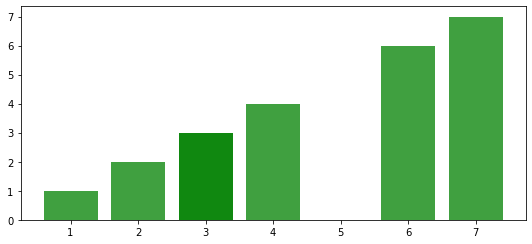